# Example 1: RGNNs for Social Networks
Copy in text from overleaf

## Introduction

## Setup

In [18]:
import numpy as np
import networkx as nx
import itertools

import matplotlib.animation as animation
import matplotlib.pyplot as plt

import dgl
from dgl.nn.pytorch import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

## Datasets

## Architectures

## Results and Discussion

In [2]:
# Test install worked

In [6]:
def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [7]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


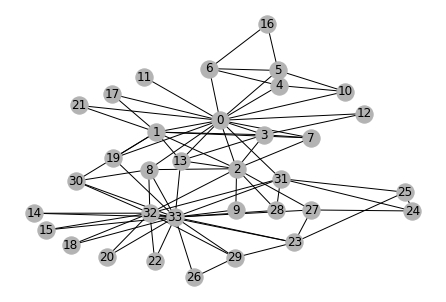

In [8]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [10]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

In [13]:
# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([ 1.9322,  1.2719, -0.2258,  0.7536, -0.0541], grad_fn=<SelectBackward>)
tensor([[-1.0931,  0.7472,  0.3706,  1.0147,  0.2361],
        [ 0.2483,  0.6251,  1.4219,  0.5671, -0.4830]],
       grad_fn=<IndexBackward>)


In [14]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

In [15]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [17]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6590
Epoch 1 | Loss: 0.6151
Epoch 2 | Loss: 0.5779
Epoch 3 | Loss: 0.5460
Epoch 4 | Loss: 0.5175
Epoch 5 | Loss: 0.4908
Epoch 6 | Loss: 0.4655
Epoch 7 | Loss: 0.4417
Epoch 8 | Loss: 0.4183
Epoch 9 | Loss: 0.3956
Epoch 10 | Loss: 0.3719
Epoch 11 | Loss: 0.3482
Epoch 12 | Loss: 0.3246
Epoch 13 | Loss: 0.3006
Epoch 14 | Loss: 0.2769
Epoch 15 | Loss: 0.2540
Epoch 16 | Loss: 0.2319
Epoch 17 | Loss: 0.2105
Epoch 18 | Loss: 0.1898
Epoch 19 | Loss: 0.1703
Epoch 20 | Loss: 0.1521
Epoch 21 | Loss: 0.1355
Epoch 22 | Loss: 0.1202
Epoch 23 | Loss: 0.1064
Epoch 24 | Loss: 0.0939
Epoch 25 | Loss: 0.0825
Epoch 26 | Loss: 0.0724
Epoch 27 | Loss: 0.0636
Epoch 28 | Loss: 0.0559
Epoch 29 | Loss: 0.0491
Epoch 30 | Loss: 0.0433
Epoch 31 | Loss: 0.0381
Epoch 32 | Loss: 0.0336
Epoch 33 | Loss: 0.0298
Epoch 34 | Loss: 0.0264
Epoch 35 | Loss: 0.0235
Epoch 36 | Loss: 0.0210
Epoch 37 | Loss: 0.0188
Epoch 38 | Loss: 0.0169
Epoch 39 | Loss: 0.0152
Epoch 40 | Loss: 0.0138
Epoch 41 | Loss: 0.0125
Ep